In [1]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
def awgn(iq, scale):
    r =  iq
    # r = np.copy(iq)
    r.real += np.random.normal(scale=scale, size=iq.shape)
    r.imag += np.random.normal(scale=scale, size=iq.shape)
    return r
    
    
def snr(pure, noisy):
    sig_pow = np.nanmean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.nanmean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

def postprocess(x):
    pyh = x
    pyh = pyh[bit_reversed_indexes(fft_size)]
    pyh = np.fft.fftshift(pyh)
    pyh = [complex(x) for x in pyh]
#     pyh = np.abs(pyh)
    pyh = pyh * np.conjugate(pyh)
#     pyh = pyh / pyh.max()
    return pyh.real

    a = 20 * np.log10(pyh 
#                       + 0.0000000000000000000001
                     ) # add small number to avoid div by 0
    return a


from pyha import Hardware, simulate, sims_close, Complex, Sfix, scalb

results = {}

In [171]:
fft_size = 32
def W(k, N):
    """ e^-j*2*PI*k*n/N, argument k = k * n """
    return np.exp(-1j * (2 * np.pi / N) * k)

twid =  np.array([W(i, fft_size) for i in range(fft_size//2)])
twid.shape

twid2 =  np.array([W(i, fft_size//2) for i in range(fft_size//4)])
twid.shape

(16,)

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


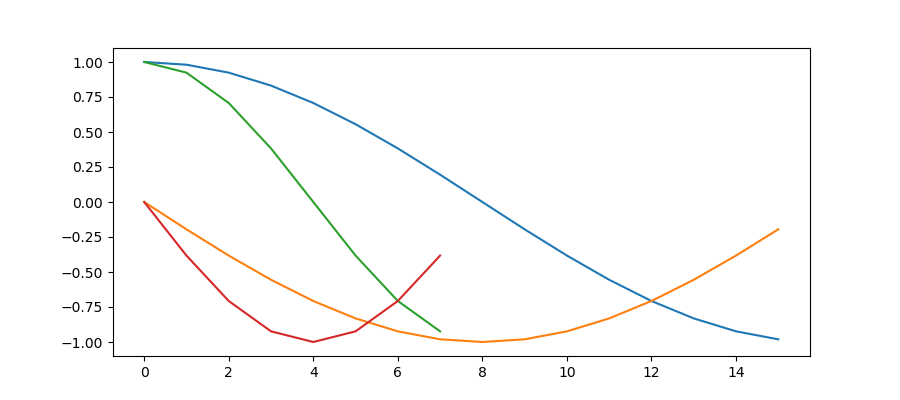

In [173]:
plt.plot(twid.real)
plt.plot(twid.imag)
plt.plot(twid2.real)
plt.plot(twid2.imag)
plt.show()


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


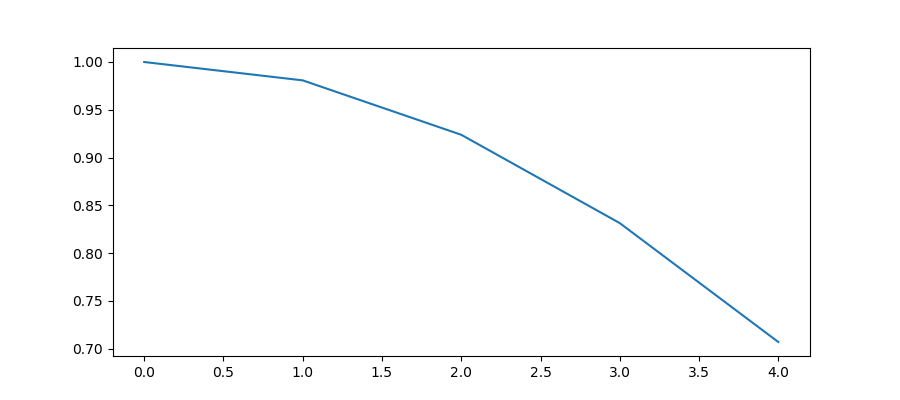

In [51]:
base_real = twid[:5].real
base_imag = twid[:5].imag

rec_real  = np.hstack([base_real, -base_imag[2:0]])
plt.plot(rec_real)
# plt.plot(rec.imag)
plt.show()

In [50]:
bin(np.invert(5))

'-0b110'

In [52]:
bin(np.invert(6))

'-0b111'

In [53]:
bin(np.invert(7))

'-0b1000'

In [164]:
class Twiddle(Hardware):
    def __init__(self, fft_size, twiddle_bits=18):
        self.CONTROL_MASK = (fft_size // 4 - 1)
        self.TWIDDLES = [W(i, fft_size) for i in range(fft_size//8+1)]
        self.BANK_SPLIT = fft_size//8+1
        self.BANK_SPLIT2 = fft_size//4
        self.BANK_SPLIT3 = fft_size//4 + fft_size//8+1
        self.SECOND_BANK_OFFSET = self.CONTROL_MASK

    def main(self, control):
        addr = control & self.CONTROL_MASK
        if control < self.BANK_SPLIT:
            print('BANK1',addr)
            return self.TWIDDLES[addr]
        elif control < self.BANK_SPLIT2:
            addr =  self.SECOND_BANK_OFFSET - addr + 1
            print('BANK2',addr)
            twid = self.TWIDDLES[addr]
            return -twid.imag + (-twid.real*1j)
        elif control < self.BANK_SPLIT3:
            print('BANK3',addr)
            twid = self.TWIDDLES[addr]
            return twid.imag + (-twid.real*1j)
        else:
            addr =  self.SECOND_BANK_OFFSET - addr + 1
            print('BANK4',addr)
            twid = self.TWIDDLES[addr]
            return -twid.real + (twid.imag*1j)


In [169]:
dut = Twiddle(64)
print(dut.CONTROL_MASK)
inp = list(range(32))
ret = [dut.main(x) for x in inp]
ret

15
BANK1 0
BANK1 1
BANK1 2
BANK1 3
BANK1 4
BANK1 5
BANK1 6
BANK1 7
BANK1 8
BANK2 7
BANK2 6
BANK2 5
BANK2 4
BANK2 3
BANK2 2
BANK2 1
BANK3 0
BANK3 1
BANK3 2
BANK3 3
BANK3 4
BANK3 5
BANK3 6
BANK3 7
BANK3 8
BANK4 7
BANK4 6
BANK4 5
BANK4 4
BANK4 3
BANK4 2
BANK4 1


[(1+0j),
 (0.9951847266721969-0.0980171403295606j),
 (0.9807852804032304-0.19509032201612825j),
 (0.9569403357322088-0.29028467725446233j),
 (0.9238795325112867-0.3826834323650898j),
 (0.881921264348355-0.47139673682599764j),
 (0.8314696123025452-0.5555702330196022j),
 (0.773010453362737-0.6343932841636455j),
 (0.7071067811865476-0.7071067811865475j),
 (0.6343932841636455-0.773010453362737j),
 (0.5555702330196022-0.8314696123025452j),
 (0.47139673682599764-0.881921264348355j),
 (0.3826834323650898-0.9238795325112867j),
 (0.29028467725446233-0.9569403357322088j),
 (0.19509032201612825-0.9807852804032304j),
 (0.0980171403295606-0.9951847266721969j),
 -1j,
 (-0.0980171403295606-0.9951847266721969j),
 (-0.19509032201612825-0.9807852804032304j),
 (-0.29028467725446233-0.9569403357322088j),
 (-0.3826834323650898-0.9238795325112867j),
 (-0.47139673682599764-0.881921264348355j),
 (-0.5555702330196022-0.8314696123025452j),
 (-0.6343932841636455-0.773010453362737j),
 (-0.7071067811865475-0.70710

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


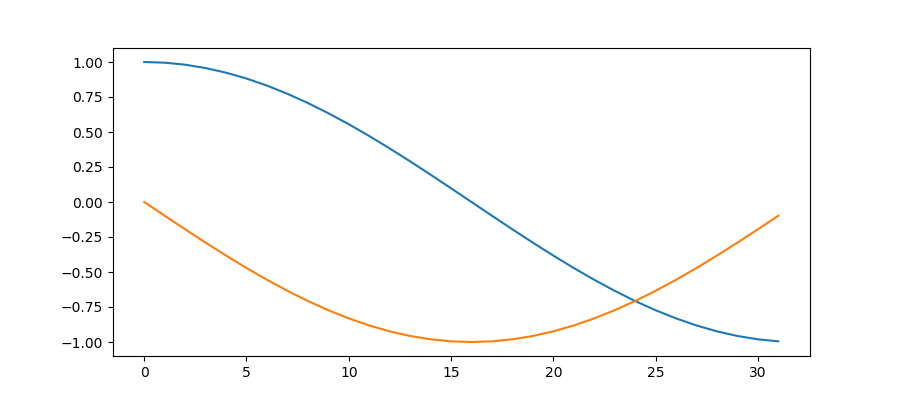

In [170]:
ret = np.array(ret)
plt.plot(ret.real)
plt.plot(ret.imag)
plt.show()